Data prep

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import torchvision


In [2]:
# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Processing of pictures and data loaders

In [3]:
# Defining directory for labels
labels_map = {0: 'not cancer', 1: 'cancer'}

In [4]:
# Define paths to the train and test pictures
train_path = "/content/drive/MyDrive/Colab Notebooks/pics/Train"
test_path = "/content/drive/MyDrive/Colab Notebooks/pics/Test"

# Function for data transformation when loading
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# Load the train and test datasets
train_dataset = datasets.ImageFolder(train_path, data_transforms)
test_dataset = datasets.ImageFolder(test_path, data_transforms)


In [7]:
# Define the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

class_names = train_dataset.classes

In [8]:
# Get a batch of images and labels for example, followed by showing them in a grit
images, labels = next(iter(train_dataloader))

# Print the labels
print('Labels:', [class_names[i] for i in labels])

Labels: ['1', '0', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0']


Labels: ['1', '0', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0']


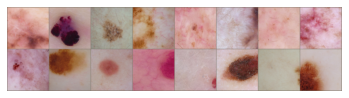

In [9]:
# Make a grid of the images
img = torchvision.utils.make_grid(images)

# Convert the batch of images to numpy format
img = img.numpy().transpose((1, 2, 0))

# Un-normalize the image data as they were normalized before
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img = img*std + mean

# Plot the images
plt.imshow(img)
plt.axis('off')

# Print the labels
print('Labels:', [class_names[i] for i in labels])

# Display the plot
plt.show()

Modelovanie za pouzitia ResNet18 s prvotnym freezofanim parametrov, to bolo nakonec odstranene pre lepsi vysledok modelu. Last layer bol vymeneny za sigmoid pre 2 classes

In [10]:
# Load a pretrained model
model = models.resnet18(pretrained=True)

# Freeze the parameters of the pretrained model
#for param in model.parameters():
#    param.requiresGrad = False

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Replace the last layer with a Sigmoid layer for 2 classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Sequential(
            nn.Linear(num_ftrs, 2),
            nn.Sigmoid()
        )

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.0001)

In [13]:
# Define the number of training epochs
num_epochs = 20
batch_size = 32


# Define a function to train the model
def train_model(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / (batch_size*(i+1)), running_corrects.double() / (batch_size*(i+1))))
    return running_loss / len(dataloader.dataset), running_corrects.double() / len(dataloader.dataset)



# Check if a GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Initialize variables to store loss and accuracy
train_loss = 0.0
train_acc = 0.0

In [14]:
# Train the model
for epoch in range(num_epochs):
    epoch_loss, epoch_acc = train_model(model, train_dataloader, criterion, optimizer, device, epoch)
    train_loss += epoch_loss
    train_acc += epoch_acc

# Print final loss and accuracy
print("Final loss: {:.4f}, final accuracy: {:.4f}".format(train_loss / num_epochs, train_acc / num_epochs))

[1,    10] loss: 0.337 accuracy: 0.306
[1,    20] loss: 0.333 accuracy: 0.312
[1,    30] loss: 0.333 accuracy: 0.309
[1,    40] loss: 0.330 accuracy: 0.317
[1,    50] loss: 0.324 accuracy: 0.324
[1,    60] loss: 0.322 accuracy: 0.322
[1,    70] loss: 0.320 accuracy: 0.323
[1,    80] loss: 0.321 accuracy: 0.322
[1,    90] loss: 0.318 accuracy: 0.327
[1,   100] loss: 0.316 accuracy: 0.331
[1,   110] loss: 0.315 accuracy: 0.332
[2,    10] loss: 0.312 accuracy: 0.325
[2,    20] loss: 0.305 accuracy: 0.347
[2,    30] loss: 0.306 accuracy: 0.342
[2,    40] loss: 0.297 accuracy: 0.352
[2,    50] loss: 0.294 accuracy: 0.357
[2,    60] loss: 0.291 accuracy: 0.364
[2,    70] loss: 0.290 accuracy: 0.364
[2,    80] loss: 0.288 accuracy: 0.366
[2,    90] loss: 0.288 accuracy: 0.367
[2,   100] loss: 0.288 accuracy: 0.368
[2,   110] loss: 0.289 accuracy: 0.365
[3,    10] loss: 0.279 accuracy: 0.369
[3,    20] loss: 0.293 accuracy: 0.353
[3,    30] loss: 0.289 accuracy: 0.360
[3,    40] loss: 0.285 ac

In [20]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/trained_model_v3.pth')

In [15]:
# Define a function to test the model
def test_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Update statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    return running_loss / len(dataloader.dataset), running_corrects.double() / len(dataloader.dataset)

In [16]:
# Test the model on the test dataset
test_loss, test_acc = test_model(model, test_dataloader, criterion, device)

In [17]:
# Print the test loss and accuracy
print("Test loss: {:.4f}, test accuracy: {:.4f}".format(test_loss, test_acc))

Test loss: 0.5816, test accuracy: 0.7059


In [18]:
# Visualize the confusion matrix to evaluate the model
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true labels and predicted labels
true_labels = []
pred_labels = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy().tolist())
        pred_labels.extend(preds.cpu().numpy().tolist())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print(cm)

[[31  7]
 [13 51]]


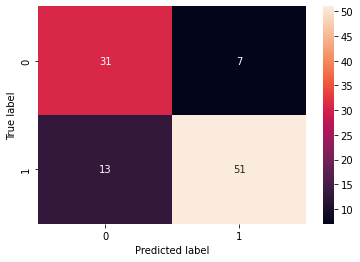

In [19]:
# Visualize the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()